# Prerequisites and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statistics

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from numpy import mean




# Load Training Data

In [2]:
drive.mount('/content/drive')
training1 = pd.read_csv('/content/drive/My Drive/FML_Data/training1.csv')
training2 = pd.read_csv('/content/drive/My Drive/FML_Data/training2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-processing

In [3]:
# Function that drops data with low confidence (below 66%)
def dropLowConf(data):
  data.drop(data.loc[data['confidence'] == 0.66].index, inplace=True)
  return data

# Function seperates CNN and GIST features in dataset
def getFeatureData(data):
  dropLowConf(data)
  features = list(data.columns.values)
  CNN_features = []
  GIST_features = []
  for feature in features:
    if("CNNs." in feature):
      CNN_features.append(feature)
    if("GIST." in feature):
      GIST_features.append(feature)
  CNN_data = data[CNN_features]
  GIST_data = data[GIST_features]
  return CNN_data, GIST_data

# Pre-processing data
def preProcessing(data):
  # convert a dataframe into an array
  data_array = data.values
  # Input normalization: Normalization
  scaler = MinMaxScaler(feature_range = (0,1))
  data_normalization = scaler.fit_transform(data_array)
  # Imputing
  imputer = SimpleImputer(strategy='mean')
  data_imputing = imputer.fit_transform(data_normalization)
  # dimensionality reduction
  pca = PCA(n_components=10)
  data_pca = pca.fit_transform(data_imputing) 
  #draw plot
  plt.scatter(data_pca[:,0],data_pca[:,1])
  return data_pca

# evaluate model
def evaluateModel(model, train_x, train_y):
  # K fold resampling 
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	return cross_val_score(model, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1)

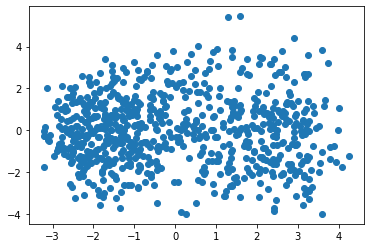

In [4]:
data = training2

CNN_data, GIST_data = getFeatureData(data)
# get training data and label data
properties = list(data.columns.values)
properties.remove('label')
pro_data = data[properties]
train_label = data['label']
train_data = preProcessing(pro_data)

## Importance Getter

In [5]:
# Function calculates and returns the importance of a data
def getImportance(data):
  x_train, x_test, y_train, y_test = train_test_split(data, train_label, test_size=0.25, random_state=42)
  ss = MinMaxScaler(feature_range = (0,1))
  x_train_scaled = ss.fit_transform(x_train)
  X_test_scaled = ss.transform(x_test)

  model = XGBClassifier()
  model.fit(x_train_scaled, y_train)
  importances = pd.DataFrame(data={
      'Attribute': x_train.columns,
      'Importance': model.feature_importances_
  })
  return statistics.mean(model.feature_importances_)


In [6]:
CNN_importances = getImportance(CNN_data)
GIST_importances = getImportance(GIST_data)
print(CNN_importances)
print(GIST_importances)

0.00024420026
0.0019569471


## Data Imputation

mean: 0.741
median: 0.741
most_frequent: 0.750
constant: 0.750


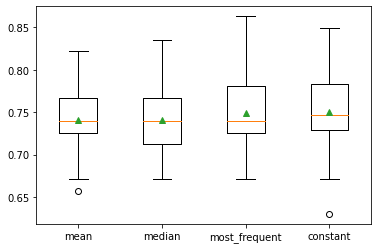

In [7]:
# test appropriate imputing methods
results = []
strategies = ['mean', 'median', 'most_frequent', 'constant']
for strategy in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(steps=[('i', SimpleImputer(strategy = strategy)), ('m', RandomForestClassifier())])
	# evaluate the model
	cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
	scores = cross_val_score(pipeline, pro_data, train_label, scoring='accuracy', cv = cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('%s: %.3f' % (strategy, mean(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()


In [8]:
# get the dataset
data_array = data.values
scaler = MinMaxScaler(feature_range = (0,1))
data_normalization = scaler.fit_transform(data_array)
imputer = SimpleImputer(strategy='mean')
data_imputing = imputer.fit_transform(data_normalization)

# get a list of models to evaluate
def get_models():
	models = {}
	for i in range(1,21):
		steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

# get the models to evaluate
models = get_models()

# evaluate the models and store results
names = [] 
results = []
for name, model in models.items():
	scores = evaluateModel(model, data_imputing, train_label)
	results.append(scores)
	names.append(name)
	print('%s: %.3f' % (name, mean(scores)))

1: 0.722
2: 0.728
3: 0.728
4: 0.751
5: 0.749
6: 0.752
7: 0.753
8: 0.755
9: 0.755
10: 0.759
11: 0.756
12: 0.748
13: 0.751
14: 0.757
15: 0.757
16: 0.754
17: 0.751
18: 0.760
19: 0.759
20: 0.757


# Select, Train and Test the Model

Accuracy score of Naive Bayes : 0.737776 (0.043671)
Accuracy score of Logistic Regression : 0.745977 (0.040407)
Accuracy score of Linear Discriminant Analysis : 0.748710 (0.040702)
Accuracy score of Random Forest Classifier : 0.736875 (0.041995)
Accuracy score of Support Vector Machine : 0.743688 (0.043344)
Accuracy score of Multi-layer Perceptron Classifier : 0.713149 (0.041775)
Accuracy score of K-Nearest Neighbors : 0.688078 (0.043196)


Text(0, 0.5, 'Accuracy Score')

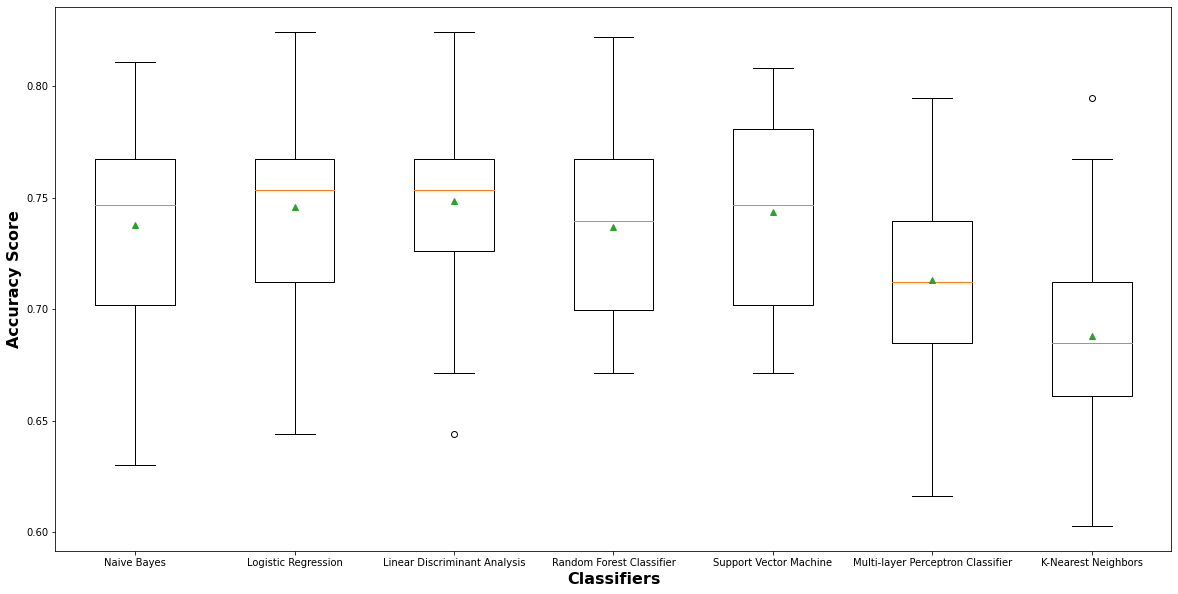

In [9]:
# test basic classifiers
def get_models():
  models = dict()
  models['Naive Bayes'] = GaussianNB()
  models['Logistic Regression'] = LogisticRegression()
  models['Linear Discriminant Analysis'] = LinearDiscriminantAnalysis()
  models['Random Forest Classifier'] = RandomForestClassifier()
  models['Support Vector Machine'] = SVC(probability=True)
  models['Multi-layer Perceptron Classifier'] = MLPClassifier()
  models['K-Nearest Neighbors'] = KNeighborsClassifier()
  return models

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results = [] 
names = []
for name, model in models.items():
  scores = evaluateModel(model, train_data, train_label)
  results.append(scores)
  names.append(name)
  print('Accuracy score of %s : %f (%f)' % (name, mean(scores), std(scores)))
 
# boxplot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.boxplot(results, labels=names, showmeans=True)
ax.set_xlabel('Classifiers', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=16, fontweight='bold')


In [10]:
# Selecting features using RFE
def get_models():
  models = {}
  rfe = RFE(estimator=GaussianNB(), n_features_to_select=3)
  model = LogisticRegression()
  models['Naive Bayes'] = Pipeline(steps=[('s',rfe),('m',model)])
  
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3)
  model = LogisticRegression()
  models['Logistic Regression'] = Pipeline(steps=[('s',rfe),('m',model)])
  
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3)
  model = estimator=SVC(probability=True)
  models['Support Vector Machine'] = Pipeline(steps=[('s',rfe),('m',model)])
	
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3)
  model = RandomForestClassifier()
  models['Random Forest Classifier'] = Pipeline(steps=[('s',rfe),('m',model)])
	 
  rfe = RFE(estimator= LogisticRegression(), n_features_to_select=3)
  model = MLPClassifier()
  models['Multi-layer Perceptron Classifier'] = Pipeline(steps=[('s',rfe),('m',model)])
  return models

results = []
names = []

models = get_models()
# evaluate the models and store results
for name, model in models.items():
  scores = evaluateModel(model, train_data, train_label)
  results.append(scores)
  names.append(name)
  print('Accuracy score of %s : %f' % (name, mean(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", line

Accuracy score of Naive Bayes : nan
Accuracy score of Logistic Regression : 0.731383
Accuracy score of Support Vector Machine : 0.731365
Accuracy score of Random Forest Classifier : 0.692657
Accuracy score of Multi-layer Perceptron Classifier : 0.727706


## Logistic Regression

In [11]:
model = LogisticRegression()

param_grid = [
    {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter' : [100,110,120,130,140],
    'dual':[True,False]
    }
]

# Grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search  = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(train_data, train_label)

print("Best Logistic Regression: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best Logistic Regression: 0.748704 using {'C': 11.288378916846883, 'dual': True, 'max_iter': 140, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21000 fits failed out of a total of 36000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError

In [12]:
# C value for best logistic regression
C_LR = 11.288378916846883

## Gaussian Naive Bayes

In [13]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, param_grid=params_NB,cv=cv,verbose=1,scoring='accuracy') 
gs_NB.fit(train_data, train_label)
gs_NB.best_params_


Fitting 30 folds for each of 100 candidates, totalling 3000 fits


{'var_smoothing': 0.04328761281083057}

In [14]:
# Storing var_smoothing value
var_sm_NB = 0.08111308307896872

## Multi-layer Perceptron Classifier

In [15]:
# define models and parameters
model = MLPClassifier(max_iter=100)
param_grid = [
    { 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
     }
]

# Grid search
grid_search  = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_result = grid_search.fit(train_data, train_label)

print("Best MLPClassifier: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best MLPClassifier: 0.749790 using {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [16]:
def get_models():
  models = {}
  models['Naive Bayes2'] =GaussianNB(var_smoothing=var_sm_NB)
  models['Logistic Regression2'] = LogisticRegression(penalty='l2', C=C_LR,solver='liblinear', max_iter = 100)
  models['Linear Discriminant Analysis'] = LinearDiscriminantAnalysis()
  models['Multi-layer Perceptron Classifier2'] = MLPClassifier(max_iter=100, activation='tanh', alpha= 0.0001, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='adam')
  return models

Accuracy score of Naive Bayes2 : 0.742324
Accuracy score of Logistic Regression2 : 0.745977
Accuracy score of Linear Discriminant Analysis : 0.748710
Accuracy score of Multi-layer Perceptron Classifier2 : 0.745520


Text(0, 0.5, 'Accuracy Score')

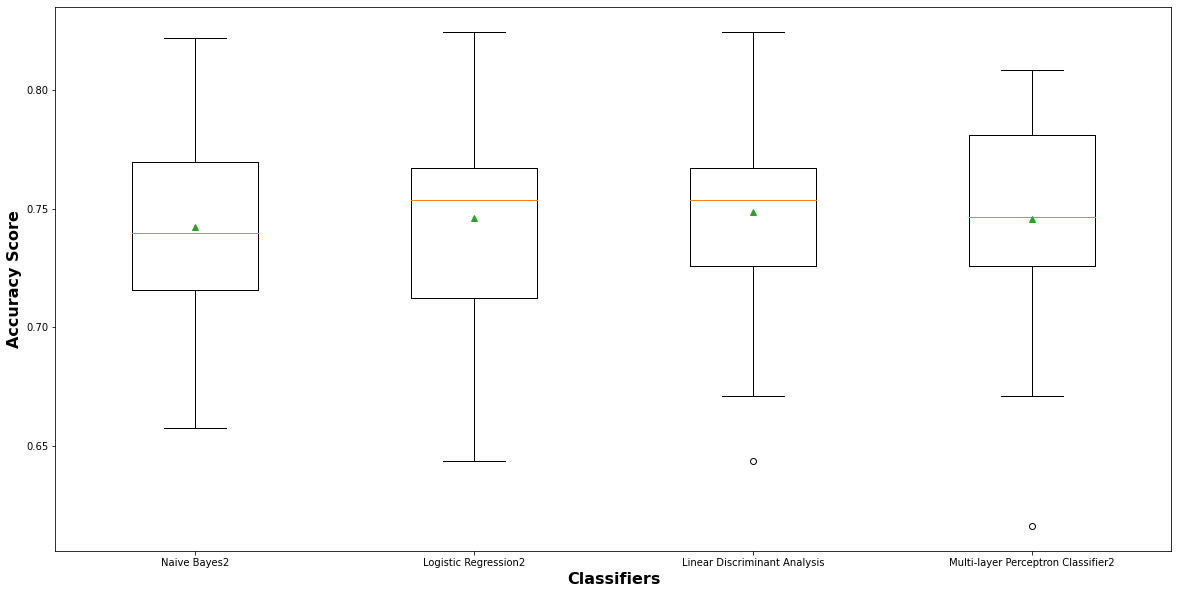

In [17]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results = []
names = []
for name, model in models.items():
  scores = evaluateModel(model, train_data, train_label)
  results.append(scores)
  names.append(name)
  print('Accuracy score of %s : %f' % (name, mean(scores)))
 
# Boxplot
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
ax.boxplot(results, labels=names, showmeans=True)
ax.set_xlabel('Classifiers', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=16, fontweight='bold')


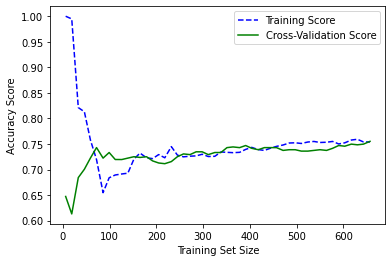

In [18]:
# draw learning curve for logistic regression
model=LogisticRegression(penalty='l2', C=C_LR, solver='liblinear',max_iter = 100)

# cv is the number of folds while performing Cross Validation
sizes, training_scores, testing_scores = learning_curve(model, train_data, train_label, cv=10, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))
  
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training Score")
plt.plot(sizes, mean_testing, color="g", label="Cross-Validation Score")
  
# Drawing plot
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.show()

In [19]:
test = pd.read_csv('/content/drive/My Drive/FML_Data/test.csv')

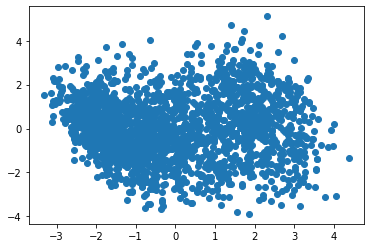

In [20]:
test_data=preProcessing(test)
# fit final model
model=LogisticRegression(penalty='l2',C=C_LR,solver='liblinear',max_iter = 100)
model.fit(train_data,train_label)
predictions = model.predict(test_data)

In [21]:
predictions
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')

In [22]:
# get the models to evaluate
model = LogisticRegression(penalty='l2',C=C_LR,solver='liblinear',max_iter = 100)
# evaluate the models and store results
scores = evaluateModel(model, train_data, train_label)
print('Accuracy score: %f ' % (mean(scores)))


Accuracy score: 0.745977 
